### COVID Labor Market

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [12]:
cols = ['MONTH', 'YEAR', 'AGE', 'FEMALE', 'LFS', 'NOTATWORK', 
        'NILFREASON', 'PTECON', 'WORKFT', 'BASICWGT', 'MJH',
        'LAYOFF']
date_cols = ['YEAR', 'MONTH', 'DAY']
date = lambda x: pd.to_datetime(x[['YEAR', 'MONTH', 'DAY']])
age_grp = lambda x: pd.cut(x.AGE, list(range(16, 83, 4)))

femp = lambda x: np.where((x.WORKFT == 1) | 
                          ((x.LFS == 'Employed') & 
                           (x.PTECON == 0) & 
                           (x.NOTATWORK == 0)), 1, 0)

emptype = lambda x: np.where(x.MJH == 1, 'MJH', 
                    np.where(x.FEMP == 1, 'FEMP',
                    np.where(x.PTECON == 1, 'PTECON',
                    np.where(x.NOTATWORK == 1, 'NOTATWORK', 0))))

master = lambda x: pd.Categorical(
                    np.where(x.LFS == 'Employed', x.EMPTYPE,
                    np.where(x.LFS == 'NILF', x.NILFREASON,
                    np.where(x.LFS == 'Unemployed', x.LAYOFF, np.nan))))

df = (pd.concat([pd.read_feather(f'cps{year}.ft', columns=cols) 
                 for year in [2019, 2021]])
        .query('BASICWGT > 0 and AGE >= 16')
        .assign(DAY = 1, DATE = date, AGE_GRP = age_grp,
                FEMP = femp, EMPTYPE = emptype, MASTER = master)
        .drop(date_cols, axis=1))

pre_start, pre_end = '2019-10-01', '2019-11-01'
cov_start, cov_end = '2021-10-01', '2021-11-01'

pre = df.query('DATE >= @pre_start and DATE <= @pre_end')
cov = df.query('DATE >= @cov_start and DATE <= @cov_end')
    
co = (cov.groupby('LFS').BASICWGT.sum() / cov.BASICWGT.sum())
pr = (pre.groupby('LFS').BASICWGT.sum() / pre.BASICWGT.sum())

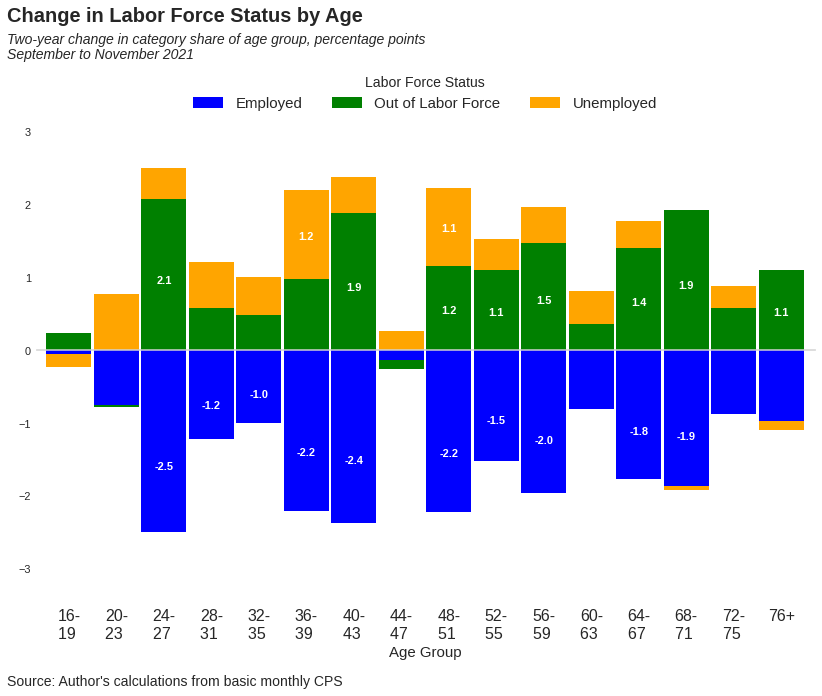

In [13]:
co = (cov.groupby(['AGE_GRP', 'LFS']).BASICWGT.sum() / 
      cov.groupby('AGE_GRP').BASICWGT.sum())
pr = (pre.groupby(['AGE_GRP', 'LFS']).BASICWGT.sum() / 
      pre.groupby('AGE_GRP').BASICWGT.sum())

agedt = ((co - pr).unstack().drop('nan', axis=1).dropna() * 100)

result = agedt
result = result.rename({'NILF': 'Out of Labor Force'}, axis=1)
result.name = ''
idx = [f'{i.left}-\n{i.right - 1} ' for i in result.index]
idx[-1] = f'{idx[-1][:2]}+'
result.index = idx
result.index.name = 'Age Group'
result.columns.name = 'Labor Force Status'

result.plot(kind='bar', stacked=True,
            color=['blue', 'green', 'orange'], 
            width=0.95, rot=0, figsize=(14, 10))
plt.ylim(-3.5, 3.95)
plt.axhline(y=0, color='lightgray')

for cat in result.columns:
    for i, age_group in enumerate(result.index):
        offset = (result.max().max() - result.min().min()) / 2
        val = result.loc[age_group, cat]
        if val < 0:
            offset = offset * (2/3)
        loc = (i, (val / offset))
        if cat == 'Unemployed':
            nilf_val = result.loc[age_group, 'Out of Labor Force']
            loc = (i, (val / offset) + nilf_val)
        if abs(val) > 1:
            txt = f'{val:.1f}'
        else:
            txt = ''
        plt.text(loc[0], loc[1], txt, color='white', 
                 fontsize=11, weight='bold', ha='center')
        
plt.xticks(fontsize=16)
plt.yticks(fontsize=11)
plt.xlabel('Age Group', fontsize=15)
leg = plt.legend(loc="upper center", fontsize=15, ncol=3,
                 title='Labor Force Status', title_fontsize=14)

# add title and footer
plt.text(-1.3, 4.5, 'Change in Labor Force Status by Age', 
          fontsize=20, weight='bold')

plt.text(-1.3, 4.2, "Two-year change in category share of age group, percentage points", 
          fontsize=14, style='italic')
plt.text(-1.3, 4.0, "September to November 2021", 
          fontsize=14, style='italic')

plt.text(-1.3, -4.6, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);

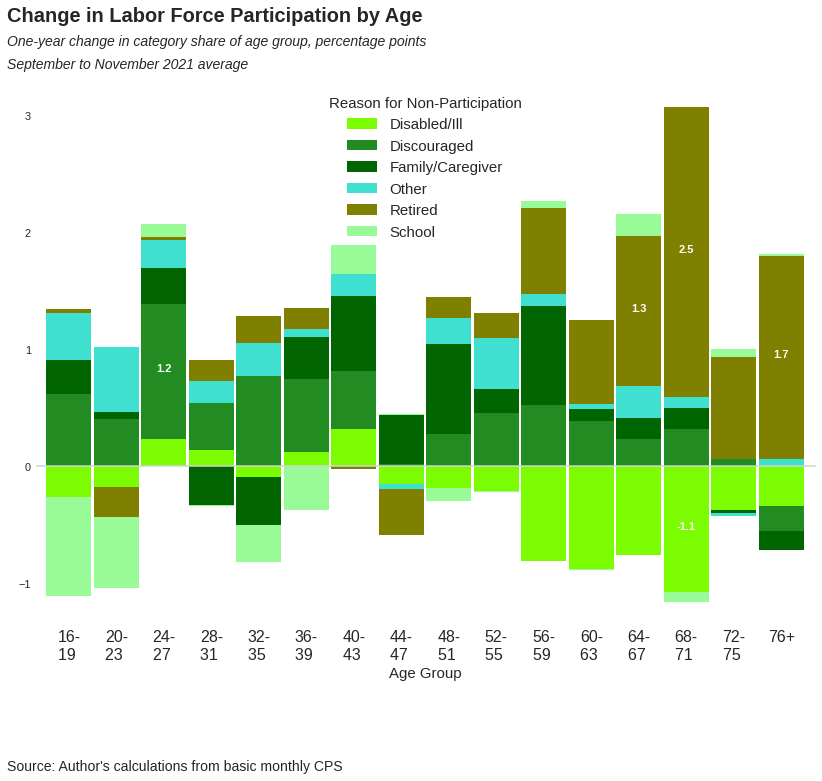

In [14]:
co = (cov.groupby(['AGE_GRP', 'NILFREASON']).BASICWGT.sum() / 
      cov.groupby('AGE_GRP').BASICWGT.sum())
pr = (pre.groupby(['AGE_GRP', 'NILFREASON']).BASICWGT.sum() / 
      pre.groupby('AGE_GRP').BASICWGT.sum())

nilfdt = (((co - pr).unstack().drop('nan', axis=1).dropna() * 100)
           .rename({'Family': 'Family/Caregiver'}, axis=1))

nilfdt.name = ''
idx = [f'{i.left}-\n{i.right - 1} ' for i in nilfdt.index]
idx[-1] = f'{idx[-1][:2]}+'
nilfdt.index = idx
nilfdt.index.name = 'Age Group'
nilfdt.columns.name = 'Out of Labor Force'

nilfdt.plot(kind='bar', stacked=True, 
           color=['lawngreen', 'forestgreen', 'darkgreen', 'turquoise', 'olive', 'palegreen'], 
           width=0.95, rot=0, figsize=(14, 10))


labels = []

# Negative values
for x, (name, row) in enumerate(nilfdt[nilfdt < 0].iterrows()):
    row = row.dropna()
    cs = row.cumsum() - (row / 2)
    for i in cs.iteritems():
        if abs(row.loc[i[0]]) > 0.9:
            y = i[1]
            val = f'{row.loc[i[0]]:.1f}'
            labels.append((x, y, val))
    
# Positive values
for x, (name, row) in enumerate(nilfdt[nilfdt >= 0].iterrows()):
    row = row.dropna()
    cs = row.cumsum() - (row / 2)
    for i in cs.iteritems():
        if abs(row.loc[i[0]]) > 0.9:
            y = i[1]
            val = f'{row.loc[i[0]]:.1f}'
            labels.append((x, y, val))

for (x, y, val) in labels:  
    plt.text(x, y, val, color='white', 
             fontsize=11, weight='bold', ha='center')            

plt.axhline(y=0, color='lightgray')

plt.xticks(fontsize=16)
plt.yticks(fontsize=11)
plt.xlabel('Age Group', fontsize=15)
plt.legend(loc="upper center", fontsize=15, ncol=1,
           title='Reason for Non-Participation', title_fontsize=15) 

leg._legend_box.align = "left"

# add title and footer
plt.text(-1.3, 3.8, 'Change in Labor Force Participation by Age', 
          fontsize=20, weight='bold')
9
plt.text(-1.3, 3.6, "One-year change in category share of age group, percentage points", 
          fontsize=14, style='italic')
plt.text(-1.3, 3.4, "September to November 2021 average", 
          fontsize=14, style='italic')

plt.text(-1.3, -2.6, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);